## Test PSF measurement in the stack

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

3


Make a couple of test images to test the PSF measurement on...

In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.
breakLimit = 1.050

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

No module named utils
LSSTSW has not been set up.
No module named utils
LSSTSW has not been set up.


Compare `psfex` and `pca` PSFs.

(25, 25) (41, 41)
0.999999974389
(25, 25) (31, 31)
1.00019083464


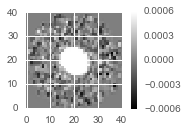

In [193]:
reload(dit)
res = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='psfex')
psf = res.psf.computeImage()
print testObj.im2.psf.shape, psf.getDimensions()
print psf.getArray().sum()

res2 = dit.measurePsf(testObj.im2.asAfwExposure(), measurePsfAlg='pca')
psf2 = res2.psf.computeImage()
print testObj.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()

dit.plotImageGrid((res.psf.computeImage().getArray(),)) #, clim=(-0.001,0.001))

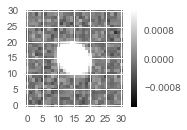

In [162]:
dit.plotImageGrid((res2.psf.computeImage().getArray(),)) #, clim=(-0.001,0.001))

See how it works on a crowded field.

In [26]:
reload(dit)
testObj2 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=500, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

#fig = plt.figure(1, (12, 12))
#dit.plotImageGrid((testObj2.im1.im,))

In [27]:
reload(dit)
res = dit.measurePsf(testObj2.im1.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')

(25, 25) (41, 41)
0.999999310446
0.999999310446
1.0
(20, 20)
(20, 20)
0.0204551598231


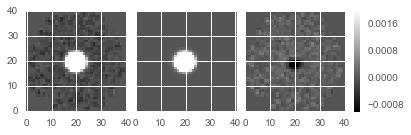

In [122]:
reload(dit)
psf1 = res.psf.computeImage()
print testObj2.im1.psf.shape, psf1.getDimensions()
print psf1.getArray().sum()

psf1a = psf1.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf1anorm = psf1a[np.abs(psf1a)>1e-3].sum()
print psf1a.sum()
psf1a /= psf1anorm

actualPsf1 = dit.makePsf(21, [1.6, 1.6], offset=[-0.35, -0.275], theta=0.)
print actualPsf1.sum()

print np.unravel_index(np.argmax(psf1a), psf1a.shape)
print np.unravel_index(np.argmax(actualPsf1), actualPsf1.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf1a - actualPsf1)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf1a, actualPsf1, actualPsf1 - psf1a), clim=(-0.001,0.002))

In [123]:
reload(dit)
res2 = dit.measurePsf(testObj2.im2.asAfwExposure(), detectThresh=10.0, measurePsfAlg='psfex')

(25, 25) (41, 41)
1.00000024971
1.16739574994 1.00000024971
0.856607752566
1.0
(20, 20)
(20, 20)
0.0235457298248


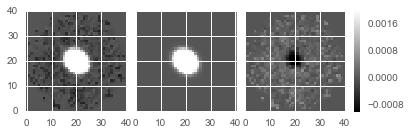

In [131]:
reload(dit)
psf2 = res2.psf.computeImage()
print testObj2.im2.psf.shape, psf2.getDimensions()
print psf2.getArray().sum()

psf2a = psf2.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
print psf2anorm, psf2a.sum()
psf2a /= psf2anorm
print psf2a.sum()

actualPsf2 = dit.makePsf(21, [1.8, 2.2], offset=[-0.2, 0.05], theta=-45.)
print actualPsf2.sum()

print np.unravel_index(np.argmax(psf2a), psf2a.shape)
print np.unravel_index(np.argmax(actualPsf2), actualPsf2.shape)
print np.sqrt(((psf2a - actualPsf2)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf2a, actualPsf2, actualPsf2 - psf2a), clim=(-0.001,0.002))

In [132]:
reload(dit)

sh = res.psf.computeShape(); print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = res2.psf.computeShape(); print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

sh = dit.arrayToAfwPsf(actualPsf1).computeShape(); 
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()
sh = dit.arrayToAfwPsf(actualPsf2).computeShape()
print sh.getDeterminantRadius(), sh.getIxx(), sh.getIyy(), sh.getIxy()

1.59599055005 2.54874905671 2.54563051264 0.00420540452585
1.96669458507 3.94293011151 3.95196589539 -0.788524516017
1.63121025049 2.63848297727 2.68718725146 0.0999584609965
1.99490612919 4.04245576994 4.08013818567 -0.810037241756


1.0 1.00000024971 1.38139652382
1.16739574994 1.00000024971
0.856607752566


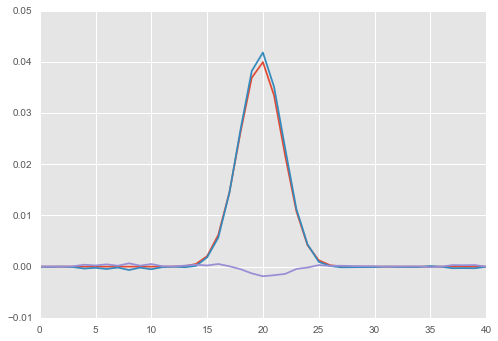

In [133]:
print np.abs(actualPsf2).sum(), psf2.getArray().sum(), np.abs(psf2.getArray()).sum()
psf2a = psf2.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf2anorm = psf2a[np.abs(psf2a)>=1e-3].sum()
print psf2anorm, psf2a.sum()
psf2a /= psf2anorm
print psf2a.sum()

plt.plot((actualPsf2)[:,20])
plt.plot((psf2a)[:,20])
plt.plot((actualPsf2 - psf2a)[:,20])

### Last test - a really crowded field.

In [164]:
reload(dit)
testObj3 = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=[1.6,1.6], psf2=[1.8,2.2],
                         offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varFlux2=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=5000, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

#fig = plt.figure(1, (12, 12))
#dit.plotImageGrid((testObj2.im1.im,))

In [190]:
reload(dit)
res3 = dit.measurePsf(testObj3.im1.asAfwExposure(), detectThresh=5.0, measurePsfAlg='psfex')

(25, 25) (41, 41)
1.00000004
1.00000004
1.0
(20, 20)
(20, 20)
0.186803683976


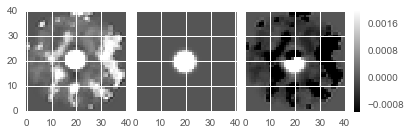

In [191]:
reload(dit)
psf3 = res3.psf.computeImage()
print testObj3.im1.psf.shape, psf3.getDimensions()
print psf3.getArray().sum()

psf3a = psf3.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf3anorm = psf3a[np.abs(psf3a)>1e-3].sum()
print psf3a.sum()
psf3a /= psf3anorm

actualPsf3 = dit.makePsf(21, [1.6, 1.6], offset=[-0.35, -0.275], theta=0.)
print actualPsf3.sum()

print np.unravel_index(np.argmax(psf3a), psf3a.shape)
print np.unravel_index(np.argmax(actualPsf3), actualPsf3.shape)
#print ((actualPsf1 - psf1.getArray())**2.).sum()
print np.sqrt(((psf3a - actualPsf3)**2.).mean()) * 100.  # compare with the violinplots from ...-Copy6.ipynb

dit.plotImageGrid((psf3a, actualPsf3, actualPsf3 - psf3a), clim=(-0.001,0.002))

1.0 1.00000004 1.01184776556
0.699625628069 0.856607752566
1.42933591892


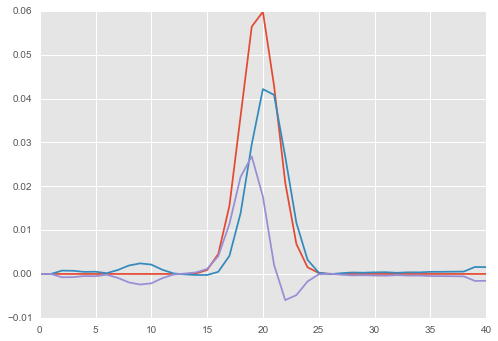

In [192]:
print np.abs(actualPsf3).sum(), psf3.getArray().sum(), np.abs(psf3.getArray()).sum()
psf3a = psf3.getArray().copy() #/ np.abs(psf2.getArray()).sum()
psf3anorm = psf3a[np.abs(psf3a)>=1e-3].sum()
print psf3anorm, psf2a.sum()
psf3a /= psf3anorm
print psf3a.sum()

plt.plot((actualPsf3)[:,20])
plt.plot((psf3a)[:,20])
plt.plot((actualPsf3 - psf3a)[:,20])